# Sentiments Analysis
## Based on comments
Data Source: https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences

#### 1) Opening the data from files

In [1]:
files_folder = './data/'
files_paths = [files_folder + i for i in ['amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt']]

#### 2) Putting the file data into lists

In [2]:
positive_reviews = []
negative_reviews = []

for file_path in files_paths:
    file = open(file_path, 'r')
    for line in file:
        suffix = -3
        if file_path == './data/imdb_labelled.txt':
            suffix = -5
        
        if int(line[-2]):
            line = line[:suffix]
            positive_reviews.append(line)
        else:
            line = line[:suffix]
            negative_reviews.append(line)

#### 3) Making syntatic data

Using combinatory functions would make the model more addicted,
so it has been used the randomic approach.

##### Calling library function

In [3]:
from random import randint, sample, seed

##### Set up

In [4]:
seed = 777
new_sentence = lambda sentences : " ".join(sample(sentences, randint(2,4)))

##### Positive

In [5]:
for i in range(200):
    syntetic = new_sentence(positive_reviews)
    positive_reviews.append(syntetic)

##### Negative

In [6]:
for i in range(200):
    syntetic = new_sentence(negative_reviews)
    negative_reviews.append(syntetic)

#### 4) Building the databases (Train/Test)

##### Import library

In [7]:
import pandas as pd

##### Process

In [8]:
sentiments_dict = {
    'review': positive_reviews + negative_reviews,
    'approval': [1 for i in positive_reviews] + [0 for i in negative_reviews]
}

df = pd.DataFrame(sentiments_dict)
del sentiments_dict, positive_reviews, negative_reviews

In [9]:
df['approval'].value_counts()

approval
1    1700
0    1700
Name: count, dtype: int64

#### 5) Clear texts

##### Importing library function

In [10]:
import re

##### Clear function

In [11]:
def clean_text(text):
    text = re.sub(r"([^\w\s])\1+", r"", text) # Removes Multiple Punctuations
    return text.lower()

##### Process

In [12]:
df['clean_review'] = df['review'].apply(clean_text)
df[['review', 'clean_review']].sample(3)

,review,clean_review
2771,I came back today since they relocated and sti...,i came back today since they relocated and sti...
1518,The aerial scenes were well-done. This is a go...,the aerial scenes were well-done. this is a go...
1265,The steaks are all well trimmed and also perfe...,the steaks are all well trimmed and also perfe...


#### 6) Stop Words Removal

##### Importing libraries

In [13]:
import nltk

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/stnz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/stnz/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/stnz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##### Set up

In [14]:
usefull_words = {"no", "nor", "not", "don'", "don't", "ain", "aren", "aren't", 
                 "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't",
                 "hadn", "hadn't", "hasn", "hasn't", "haven't", "isn", "isn't",
                 "mightn", "mightn't", "mustn", "mustn't", "needn", "needn't",
                 "shan", "shan't", "shan't", "shouldn", "shouldn't", "wasn",
                 "wasn't", "weren", "weren't", "won't", "wouldn", "wouldn't"}

stop_words = set([w for w in stopwords.words('english') if w not in usefull_words])

In [15]:
def remove_stopwords(text):
    words = nltk.word_tokenize(text)
    return " ".join([word for word in words if word not in stop_words])

##### Process

In [16]:
df['no_stopwords'] = df['clean_review'].apply(remove_stopwords)

In [17]:
df[['clean_review', 'no_stopwords']].sample(3)

,clean_review,no_stopwords
199,after trying many many handsfree gadgets this ...,trying many many handsfree gadgets one finally...
1550,you learn a lot about the real inside emotions...,"learn lot real inside emotions people movie , ..."
7,highly recommend for any one who has a blue to...,highly recommend one blue tooth phone .


#### 7) Stemming

I chose stemming beacuse it's computacional complexity is lower than lemming, 
taking into count that there are many instances of training because of the
permutations done to the original data.

##### Importing libraries

In [18]:
from nltk.stem import PorterStemmer

##### Set up

In [19]:
def stem(text):
    words = nltk.word_tokenize(text)
    stemmer = PorterStemmer()
    return " ".join([stemmer.stem(word) for word in words])    

##### Process

In [20]:
df['stemmed'] = df['no_stopwords'].apply(stem)

In [21]:
df[['no_stopwords', 'stemmed']].sample(3)

,no_stopwords,stemmed
679,) makes story different terrific production va...,) make stori differ terrif product valu - faul...
3303,"muddy , low quality sound , casing around wire...","muddi , low qualiti sound , case around wire '..."
139,love headset !,love headset !


#### 8) Bag Of Words

This method is ideal for short text (such as the ones used here).
Also it has a lower computing complexity when compared to the TF-IDF.

##### Importing library function

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

##### Process

In [23]:
cv = CountVectorizer()
X = cv.fit_transform(df['stemmed'])

#### 9) Divide Data (Train/Test)

##### Importing libraries function

In [24]:
from sklearn.model_selection import train_test_split

##### Process

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, df['approval'], test_size=0.3, random_state=777)

#### 10) Naive Bayes

##### Importing libraries function

In [26]:
from sklearn.naive_bayes import MultinomialNB

##### Train

In [27]:
classifier = MultinomialNB()
classifier.fit(X_train, Y_train)

MultinomialNB()

##### Predict

In [28]:
Y_prediction = classifier.predict(X_test)

#### 11) Results

##### Importing libraries

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

##### Plotting

##### Table

In [30]:
print("Classification Report:")
print(classification_report(Y_test, Y_prediction))

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       489
           1       0.87      0.86      0.86       531

    accuracy                           0.86      1020
   macro avg       0.86      0.86      0.86      1020
weighted avg       0.86      0.86      0.86      1020



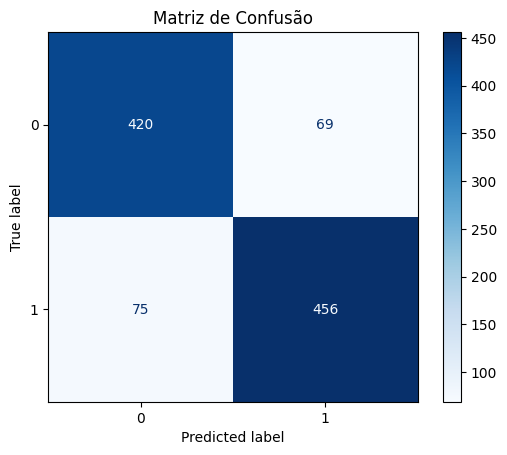

In [31]:
conf_matrix = confusion_matrix(Y_test, Y_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.show()

##### Conclusion

The model used on this notebook got a high accuracy for the test sample.
This mean that this model may be great for estimating the approval of clients based on their comments.